In [251]:
import pandas as pd
import numpy as np
import json

import networkx as nx

from tqdm import tqdm

from compound import Compound
from reaction import Reaction
from graph import Graph
from data import Data

# create class instances
data = Data()
graph = Graph()

# read data from csv
cpds = pd.read_csv('data/compounds_final.csv', index_col=0)
rxns = pd.read_csv('data/reactions_final.csv', index_col=0)
pairs = pd.read_csv('data/pairs_final.csv', index_col=0)
cofactors = pd.read_csv('data/original/cofactors_KEGG.csv')

# Create a Compound object for each row in the DataFrame and add it to the data
for index, row in cpds.iterrows():
    entry = row['Entry']
    name = row['Names']
    formula = row['Formula']
    mw = row['mol_weight']
    smiles = row['SMILES']
    is_cofactor = row['Entry'] in cofactors['Entry'].values

    compound = Compound(entry, name, formula, mw, smiles, is_cofactor)
    data.add_element('compound', compound)

# Create a Reaction object for each row in the DataFrame and add it to the data
for index, row in rxns.iterrows():
    entry = row['Entry']
    name = row['Names']
    compounds = row['Compound']
    enzyme = row['EC Number']

    reaction = Reaction(entry, name, compounds, enzyme)
    data.add_element('reaction', reaction)


# number of times a metabolite apperas on pairs dataset
graph.get_number_of_occurences(pairs)

# Create Graph
graph.create_graph(data=data, pairs=pairs)

''' 
*******************************************
Validate the methods on validation datasets 
*******************************************
'''
######### VALIDATION SET FROM nicepath ###########
test_cases = pd.read_csv('data/original/test_cases.csv')
test_cases['source'] = test_cases['Pathway '].apply(lambda x: x.split(',')[0])
test_cases['target'] = test_cases['Pathway '].apply(lambda x: x.split(',')[len(x.split(','))-1])
test_cases['paths_list'] = test_cases['Pathway '].apply(lambda x: x.split(','))

paths = graph.simple_weighted_shortest_path(test_cases=test_cases, data=data, method='mol_weight')

# ######### NEW VALIDATION SET ###########
# pyminer_test = pd.read_csv('data/original/pyminer_validation_set.csv', delimiter=';', header=None, names=['Pathway'])
# pyminer_test['source'] = pyminer_test['Pathway'].apply(lambda x: x.split(',')[0])
# pyminer_test['target'] = pyminer_test['Pathway'].apply(lambda x: x.split(',')[len(x.split(','))-1])
# pyminer_test['paths_list'] = pyminer_test['Pathway'].apply(lambda x: x.split(','))

# print('Simple weighted shortes paths:')
# paths = graph.simple_weighted_shortest_path(test_cases=pyminer_test, data=data, method='mol_weight')

# nodes: 8591 
# edges: 30081

Removing self-loops...
# nodes: 8591 
# edges: 30026


100%|██████████| 30026/30026 [00:00<00:00, 199987.89it/s]


Correct pathway predictions: 14
Correct pathway predictions (%): 28.0


# Graph learning and stuff to try

In [125]:
cpd = data.get_compound_by_id('C00082')
print(cpd)

smile = cpd.smiles
print(smile)

correct_pathway_example = paths['Pathway'].iloc[1]
print(correct_pathway_example)

correct_subgraph = graph.G.subgraph(correct_pathway_example)
print(correct_subgraph.nodes())

ID: C00082
Name: ["L-Tyrosine", "(S)-3-(p-Hydroxyphenyl)alanine", "(S)-2-Amino-3-(p-hydroxyphenyl)propionic acid", "Tyrosine"]
Formula: C9H11NO3

N[C@@H](Cc1ccc(O)cc1)C(=O)O
['C00223', 'C12096', 'C00029', 'C00761']


AttributeError: 'Graph' object has no attribute 'G'

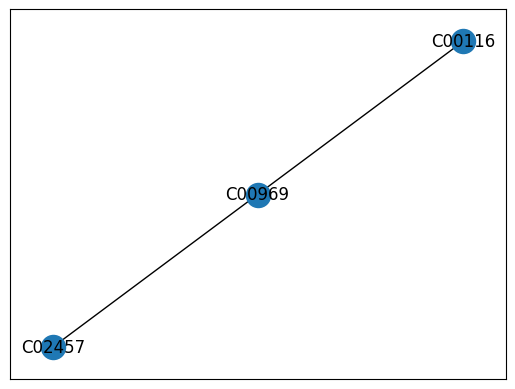

In [126]:
G = correct_subgraph.copy()
nx.draw_networkx(G)

from torch_geometric.utils.convert import from_networkx

pyg_graph = from_networkx(G)

In [127]:
pyg_graph.y = 1
print(pyg_graph)

Data(edge_index=[2, 4], mw=[3], mol_weight=[4], num_nodes=3, y=1)


In [128]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv
from torch_geometric.nn import global_mean_pool
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_channels, conv, conv_params={}):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = conv(
            input_size, hidden_channels, **conv_params)
        
        self.conv2 = conv(
            hidden_channels, hidden_channels, **conv_params)
        
        self.lin = Linear(hidden_channels, 2)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        
        # Readout layer
        batch = torch.zeros(data.x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x
    
model = GNN(input_size=1, hidden_channels=3, conv=GCNConv)
print(model)

GNN(
  (conv1): GCNConv(1, 3)
  (conv2): GCNConv(3, 3)
  (lin): Linear(in_features=3, out_features=2, bias=True)
)


#### My try

In [261]:
gg = graph.G

In [262]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch_geometric
import torch

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global mean pooling to obtain graph-level representation
        x = torch_geometric.nn.global_mean_pool(x, batch)

        return x

In [263]:
master_G = gg.copy()
print(master_G.nodes())

# mapping = {node: idx for idx, node in enumerate(master_G.nodes())}
# master_G = nx.relabel_nodes(master_G, mapping)

['C00013', 'C00009', 'C00001', 'C01010', 'C00011', 'C00014', 'C00900', 'C00022', 'C06033', 'C00027', 'C00007', 'C01083', 'C00031', 'C19610', 'C19611', 'C00080', 'C00044', 'C01261', 'C00048', 'C01146', 'C05125', 'C00068', 'C00089', 'C03661', 'C00125', 'C00126', 'C00134', 'C06366', 'C00138', 'C00282', 'C00139', 'C00025', 'C00064', 'C00026', 'C01674', 'C00140', 'C00192', 'C01818', 'C00004', 'C00003', 'C01182', 'C00197', 'C18091', 'C00084', 'C00088', 'C00061', 'C01847', 'C00185', 'C00221', 'C01408', 'C00261', 'C00208', 'C00320', 'C02084', 'C00355', 'C00082', 'C02094', 'C00376', 'C00378', 'C05856', 'C00430', 'C00931', 'C00479', 'C02948', 'C00492', 'C08242', 'C00339', 'C00609', 'C01179', 'C00642', 'C04547', 'C00755', 'C01795', 'C00757', 'C00822', 'C01059', 'C00028', 'C01020', 'C00030', 'C04546', 'C01089', 'C01158', 'C04101', 'C01334', 'C01371', 'C01327', 'C01572', 'C01424', 'C02868', 'C01839', 'C00294', 'C01993', 'C01910', 'C02171', 'C02318', 'C01525', 'C02351', 'C00090', 'C01255', 'C02378',

In [264]:
graphs = []
labels = []

for row in range(len(paths)):
    sg = master_G.subgraph(paths['Pathway'].iloc[row])
    graphs.append(sg)

    if paths['Correct'].iloc[row]: label = 1
    else: label = 0

    labels.append(label)

print("Graphs:", graphs)
print("Labels:", labels)

Graphs: [<networkx.classes.graph.Graph object at 0x7f62159ed790>, <networkx.classes.graph.Graph object at 0x7f616928ef70>, <networkx.classes.graph.Graph object at 0x7f61693733d0>, <networkx.classes.graph.Graph object at 0x7f6169373670>, <networkx.classes.graph.Graph object at 0x7f6169373d00>, <networkx.classes.graph.Graph object at 0x7f6169373dc0>, <networkx.classes.graph.Graph object at 0x7f6169373910>, <networkx.classes.graph.Graph object at 0x7f61693732e0>, <networkx.classes.graph.Graph object at 0x7f62159e89d0>, <networkx.classes.graph.Graph object at 0x7f62159e8040>, <networkx.classes.graph.Graph object at 0x7f62159e8fa0>, <networkx.classes.graph.Graph object at 0x7f62159e84c0>, <networkx.classes.graph.Graph object at 0x7f62159e8970>, <networkx.classes.graph.Graph object at 0x7f62159e8460>, <networkx.classes.graph.Graph object at 0x7f6169380850>, <networkx.classes.graph.Graph object at 0x7f6169380490>, <networkx.classes.graph.Graph object at 0x7f6169380cd0>, <networkx.classes.grap

In [266]:
graphs[1].nodes(data=True)

NodeDataView({'C00029': {'mw': 566.302}, 'C00761': {'mw': 342.336}, 'C00223': {'mw': 913.686}, 'C12096': {'mw': 757.656}})

In [ ]:
# Convert Networkx graph to PyTorch Geometric Data object
def convert_networkx_to_pyg(graph):
    # Extract node features
    node_features = [graph.nodes[node]['mw'] for node in graph.nodes()]

    # Extract edge features if available
    edge_index = []
    edge_attr = []

    for edge in graph.edges():
        src, tgt = edge
        edge_index.append([src, tgt])
        # Add edge attribute extraction code if available

    # Create PyTorch Geometric Data object
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return data

# Convert networkx graph to PyTorch Geometric Data object
data = convert_networkx_to_pyg(graph)

# Print the converted data
print(data)

In [268]:
# Convert NetworkX graphs to PyG data
data_list = []
for graph, label in zip(graphs, labels):
    # rename nodes to integers    
    mapping = {node: idx for idx, node in enumerate(graph.nodes())}
    graph = nx.relabel_nodes(graph, mapping)

    # Convert NetworkX graph to PyG data
    x = torch.tensor([graph.nodes[node]['mw'] for node in graph.nodes], dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    edge_attr = torch.tensor([graph.edges[edge]['mol_weight'] for edge in graph.edges], dtype=torch.float)
    y = torch.tensor([label])  # Graph-level label

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data_list.append(data)

# Concatenate all data samples into a single PyG data object
data = torch_geometric.data.Batch.from_data_list(data_list)
print(data)

DataBatch(x=[306, 1], edge_index=[2, 256], edge_attr=[256], y=[50], batch=[306], ptr=[51])


In [269]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2)

In [271]:
import torch.optim as optim

# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize GNN model
model = GCN(input_dim=1, hidden_dim=32, output_dim=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    
    total_loss = 0
    for data in train_data:
        out = model(data)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        total_loss += loss.item()
    
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

print("Training completed.")

Epoch 0, Loss: 1105.4496116638184
Epoch 10, Loss: 224.61056780801457
Epoch 20, Loss: 336.38360905522745
Epoch 30, Loss: 97.2984473136752
Epoch 40, Loss: 150.45332679403145
Epoch 50, Loss: 55.33489870877929
Epoch 60, Loss: 24.25660541653633
Epoch 70, Loss: 40.86584873608081
Epoch 80, Loss: 48.46292585518677
Epoch 90, Loss: 94.89154672005873
Training completed.


In [272]:
# Evaluation mode
model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for data in test_data:
        out = model(data)
        predicted_labels = out.argmax(dim=1)
        true_labels = data.y.view(-1)
        correct += (predicted_labels == true_labels).sum().item()
        total += len(true_labels)

    accuracy = correct / total
    print(f"Accuracy: {accuracy}")

Accuracy: 0.3


# EXAMPLE OF GRAPHNN

In [219]:
import networkx as nx
import random

# Generate random graphs with labels
num_graphs = 5
graphs = []
labels = []

for _ in range(num_graphs):
    # Generate a random graph
    graph = nx.fast_gnp_random_graph(10, 0.3)
    graphs.append(graph)
    
    # Assign a random label (Type 0 or Type 1)
    label = random.choice([0, 1])
    labels.append(label)

print("Graphs:", graphs)
print("Labels:", labels)

Graphs: [<networkx.classes.graph.Graph object at 0x7f616f1bae20>, <networkx.classes.graph.Graph object at 0x7f616f1ba280>, <networkx.classes.graph.Graph object at 0x7f616f1ba5b0>, <networkx.classes.graph.Graph object at 0x7f616f1bac10>, <networkx.classes.graph.Graph object at 0x7f616f1ba8b0>]
Labels: [1, 1, 1, 0, 1]


In [220]:
from torch_geometric.data import Data
import torch_geometric
import torch

# Convert NetworkX graphs to PyG data
data_list = []
for graph, label in zip(graphs, labels):
    # Convert NetworkX graph to PyG data
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    x = torch.randn(graph.number_of_nodes(), 16)  # Random node features (16 dimensions)
    y = torch.tensor([label])  # Graph-level label
    
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)


# Concatenate all data samples into a single PyG data object
data = torch_geometric.data.Batch.from_data_list(data_list)
data

DataBatch(x=[50, 16], edge_index=[2, 68], y=[5], batch=[50], ptr=[6])

In [62]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global mean pooling to obtain graph-level representation
        x = torch_geometric.nn.global_mean_pool(x, batch)

        return x


In [63]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2)

In [65]:
import torch.optim as optim

# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize GNN model
model = GCN(input_dim=16, hidden_dim=32, output_dim=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    
    total_loss = 0
    for data in train_data:
        out = model(data)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        total_loss += loss.item()
    
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

print("Training completed.")

Epoch 0, Loss: 1.9122719466686249
Epoch 10, Loss: 0.13940763473510742
Epoch 20, Loss: 0.016980628250166774
Epoch 30, Loss: 0.00534961384255439
Epoch 40, Loss: 0.0029825203819200397
Epoch 50, Loss: 0.0021953209943603724
Epoch 60, Loss: 0.0018333566549699754
Epoch 70, Loss: 0.0016186400898732245
Epoch 80, Loss: 0.001463850581785664
Epoch 90, Loss: 0.0013387272483669221
Training completed.


In [67]:
# Evaluation mode
model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for data in test_data:
        out = model(data)
        predicted_labels = out.argmax(dim=1)
        true_labels = data.y.view(-1)
        correct += (predicted_labels == true_labels).sum().item()
        total += len(true_labels)

    accuracy = correct / total
    print(f"Accuracy: {accuracy}")

Accuracy: 0.0
